# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [4]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path
from src.prediction import utils

In [6]:
config = json.load(open('../config.json', 'r'))
data_path = Path(config['data_path']) / 'case_study_data'

To produce the predictions, run from the project root:

`python -m src.prediction.sensitivity_prediction_datalist --datalist {your_data_path}case_study_data/graph/data_list.pickle --gpu 0 --outpath {your_data_path}/case_study_data/case_study_predictions.tsv`

In [7]:
preds = torch.load(data_path/'predictions.pt')

In [8]:
predictions = pd.read_csv(data_path/'case_study_predictions.tsv', sep='\t')

In [9]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6531 entries, 0 to 6530
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6531 non-null   int64  
 1   biomodel             6531 non-null   object 
 2   input_species        6531 non-null   int64  
 3   output_species       6531 non-null   int64  
 4   distance             6531 non-null   int64  
 5   distance_ind         6531 non-null   int64  
 6   prediction_mean      6531 non-null   float64
 7   prediction_mean_bin  6531 non-null   bool   
 8   prediction_maj       6531 non-null   bool   
 9   prediction_max       6531 non-null   float64
 10  prediction_min       6531 non-null   float64
 11  prediction_std       6531 non-null   float64
dtypes: bool(2), float64(4), int64(5), object(1)
memory usage: 523.1+ KB


# Preprocessing

In [10]:
predictions['all_preds'] = preds.T.tolist()
predictions['all_preds'] = predictions['all_preds'].apply(lambda x: [round(i, 4) for i in x])
predictions = predictions.sort_values('prediction_mean', ascending=False)
predictions.drop(columns=['Unnamed: 0'], inplace=True)
predictions.drop_duplicates(subset=['input_species','output_species','biomodel'], keep='first', inplace=True)

In [11]:
pws_titles = {
 'R-HSA-9768919': 'NPAS4 regulates expression of target genes',
 'R-HSA-210745': 'Regulation of gene expression in β-cells',
 'R-HSA-422356': 'Regulation of insulin secretion',
 'R-HSA-264876': 'Insulin processing',
 'R-HSA-163359': 'Glucagon signaling in metabolic regulation',
 'R-HSA-381771': 'Synthesis, secretion, and inactivation\nof Glucagon-like Peptide-1',
 'R-HSA-420092': 'Glucagon-type ligand receptors'
 }

INS = 109842
GCG = 108911

regulated_proteins = {109842:"INS", 108911:"GCG"}

regulators = {110096:"AFF3", 116907:"CUX2", 121913: "BACH2"}

In [12]:
predictions['description'] = predictions['biomodel'].map(pws_titles)
predictions['in_gene_name'] = predictions['input_species'].map(regulators)
predictions['out_gene_name'] = predictions['output_species'].map(regulators)

In [13]:
def norm_score(row):
    pw = row['biomodel']
    max_score = predictions[(predictions['biomodel'] == pw) & (~predictions['distance'].isin([0,1])) & (~predictions['distance_ind'].isin([0,1]))]['prediction_mean'].max()
    return row['prediction_mean'] / max_score

predictions['norm_score'] = predictions.apply(norm_score, axis=1)

# Global ranking

In [14]:
predictions[(~predictions.distance.isin([0])) & (~predictions.distance_ind.isin([0]))]\
        .groupby('input_species')\
        .agg({'prediction_mean':['sum','count','mean'],'in_gene_name':list, 'distance':'mean', 'distance_ind':'mean'})\
        .sort_values(('prediction_mean','sum'), ascending=False).reset_index().head(50)

input_species prediction_mean                  \
                             sum count      mean   
0         121913       29.171460   188  0.155167   
1         109842       24.954786   188  0.132738   
2         108911       22.358871   188  0.118930   
3         116907       19.808655   188  0.105365   
4         110096       16.847926   188  0.089617   
5         131886       14.011086   124  0.112993   
6         110043       13.048919    74  0.176337   
7         113010       12.310590   124  0.099279   
8         112038       10.695715    66  0.162056   
9         109424       10.633104   162  0.065636   
10        111384       10.590553    66  0.160463   
11        108276       10.437530    88  0.118608   
12        111860        9.869364    36  0.274149   
13        116836        8.725163    79  0.110445   
14        108912        8.580480    38  0.225802   
15        109432        8.502938   143  0.059461   
16        108959        8.323784    25  0.332951   
17        112248        7.874400    25  0.314976   
18        110358        7.770239    36  0.215840   
19        120887        7.458508    30  0.248617   
20        125200        7.244696    38  0.190650   
21        109438        7.106597    25  0.284264   
22        120881        7.101746    30  0.236725   
23        116464        6.781794    30  0.226060   
24        106630        6.683196    25  0.267328   
25        120023        6.587554    30  0.219585   
26        127206        6.587554    30  0.219585   
27        112391        6.580138    36  0.182782   
28        116867        6.531862    30  0.217729   
29        106898        6.519602    36  0.181100   
30        136270        6.388346    36  0.177454   
31        113273        6.331518    25  0.253261   
32        112180        6.277662    36  0.174379   
33        112247        6.161314    25  0.246453   
34        108636        6.137448    36  0.170485   
35        121522        5.750134    79  0.072787   
36        111105        5.713466    85  0.067217   
37        108962        5.618291    25  0.224732   
38        125743        5.600219    25  0.224009   
39        115884        5.516085    30  0.183870   
40        107455        5.307376    36  0.147427   
41        121906        5.303956    30  0.176799   
42        107603        5.222465    25  0.208899   
43        114974        5.004852    62  0.080723   
44        114746        4.881902    25  0.195276   
45        107880        4.697751    36  0.130493   
46        132759        4.119719    30  0.137324   
47        109736        3.930843    26  0.151186   
48        111073        3.786255    30  0.126209   
49        124604        3.635866    26  0.139841   

                                         in_gene_name  distance distance_ind  
                                                 list      mean         mean  
0   [BACH2, BACH2, BACH2, BACH2, BACH2, BACH2, BAC...  1.462766     3.101064  
1   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  1.723404     2.260638  
2   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ... -0.989362     3.202128  
3   [CUX2, CUX2, CUX2, CUX2, CUX2, CUX2, CUX2, CUX...  2.132979     3.212766  
4   [AFF3, AFF3, AFF3, AFF3, AFF3, AFF3, AFF3, AFF... -1.000000     2.696809  
5   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ... -1.000000     2.887097  
6   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  1.648649     2.135135  
7   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  1.419355     1.919355  
8   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  1.409091     1.803030  
9   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  1.783951     2.006173  
10  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  1.772727     2.075758  
11  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  1.420455     1.625000  
12  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  1.527778     2.194444  
13  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ... -1.000000     2.759494  
14  [nan, nan, nan, nan, nan, nan,

In [15]:
for pw, title in pws_titles.items():
    ranking = predictions[(~predictions.distance.isin([0])) & (~predictions.distance_ind.isin([0])) & predictions.biomodel.isin([pw])]\
        .groupby('input_species')\
        .agg({'prediction_mean':['sum','count','mean'],'in_gene_name':list, 'distance':'mean', 'distance_ind':'mean'})\
        .sort_values(('prediction_mean','sum'), ascending=False).reset_index().head(50)
    
    ranking['input_gene'] = ranking.input_species.map(regulators)
    print(pw, title, f"{len(ranking)} proteins")
    print(ranking[ranking.input_species.isin(regulators)][['input_gene','prediction_mean']])
    print()

R-HSA-9768919 NPAS4 regulates expression of target genes 37 proteins
   input_gene prediction_mean                
                          sum count      mean
7        AFF3        6.512674    36  0.180908
16      BACH2        4.156361    36  0.115454
27       CUX2        2.500477    36  0.069458

R-HSA-210745 Regulation of gene expression in β-cells 27 proteins
   input_gene prediction_mean                
                          sum count      mean
19       AFF3        1.165588    26  0.044830
22      BACH2        1.013257    26  0.038971
23       CUX2        0.689678    26  0.026526

R-HSA-422356 Regulation of insulin secretion 50 proteins
   input_gene prediction_mean                
                          sum count      mean
14       CUX2        0.430240    49  0.008780
38       AFF3        0.143790    49  0.002934
48      BACH2        0.012321    49  0.000251

R-HSA-264876 Insulin processing 31 proteins
   input_gene prediction_mean                
                         

In [16]:
def create_heatmap(target, pws_titles=pws_titles, norm=False):

    if norm:
        agg_dict = {'norm_score':['sum','count','mean'],'in_gene_name':list, 'distance':'mean', 'distance_ind':'mean'}
        sort_by = ('norm_score','sum')
        heatmap_value = 'norm_score'
    else:
        agg_dict = {'prediction_mean':['sum','count','mean'],'in_gene_name':list, 'distance':'mean', 'distance_ind':'mean'}
        sort_by = ('prediction_mean','sum')
        heatmap_value = 'prediction_mean'

    heatmap = np.zeros((len(regulators), len(pws_titles)))
    for p, (pw, title) in enumerate(pws_titles.items()):
        ranking = predictions[(~predictions.distance.isin([0,1])) & (predictions.output_species==target) & (~predictions.distance_ind.isin([0])) & predictions.biomodel.isin([pw])]\
            .groupby('input_species')\
            .agg(agg_dict)\
            .sort_values(sort_by, ascending=False).reset_index().head(50)
        
        ranking['input_gene'] = ranking.input_species.map(regulators)
        if not norm:
            print(pw, pws_titles[pw], f"{len(ranking)} proteins")
            print(ranking[ranking.input_species.isin(regulators)][['input_gene','prediction_mean']])
            print()

        for i, reg in enumerate(regulators):
            if reg in ranking.input_species.values:
                heatmap[i,p] = ranking[ranking.input_species==reg][heatmap_value]['sum'].iloc[0]
    
    return heatmap


In [17]:
def plot_ins_gcg_heatmap(ins_heatmap, gcg_heatmap, pws_titles, figsize=(8,15), output='case_study_results/ins_gcg_heatmap.pdf'):
    # Compute the global min and max to set the same color scale
    global_min = min(ins_heatmap.min(), gcg_heatmap.min())
    global_max = max(ins_heatmap.max(), gcg_heatmap.max())

    fig, ax = plt.subplots(1, 2, figsize=figsize)

    sns.heatmap(ins_heatmap.T, annot=True, xticklabels=[regulators[i] for i in regulators], 
                yticklabels=[pws_titles[pw] for pw in pws_titles], cmap='coolwarm', 
                ax=ax[0], vmin=global_min, vmax=global_max, cbar=False)

    sns.heatmap(gcg_heatmap.T, annot=True, xticklabels=[regulators[i] for i in regulators], 
                yticklabels=False, cmap='coolwarm', 
                ax=ax[1], vmin=global_min, vmax=global_max, cbar=False)

    ax[0].set_title('INS')
    ax[1].set_title('GCG')

    plt.savefig(output, format='pdf', bbox_inches='tight')
    plt.show()


In [18]:
os.mkdir('case_study_results')

R-HSA-9768919 NPAS4 regulates expression of target genes 35 proteins
   input_gene prediction_mean                
                          sum count      mean
11       AFF3        0.234433     1  0.234433
16      BACH2        0.175371     1  0.175371
28       CUX2        0.082893     1  0.082893



R-HSA-210745 Regulation of gene expression in β-cells 26 proteins
   input_gene prediction_mean                
                          sum count      mean
8        AFF3        0.055605     1  0.055605
16      BACH2        0.034606     1  0.034606
21       CUX2        0.022933     1  0.022933

R-HSA-422356 Regulation of insulin secretion 48 proteins
   input_gene prediction_mean                
                          sum count      mean
11       CUX2        0.014321     1  0.014321
40       AFF3        0.001536     1  0.001536
46      BACH2        0.000196     1  0.000196

R-HSA-264876 Insulin processing 29 proteins
   input_gene prediction_mean                
                          sum count      mean
0       BACH2        0.365825     1  0.365825
5        CUX2        0.139550     1  0.139550
20       AFF3        0.040891     1  0.040891

R-HSA-163359 Glucagon signaling in metabolic regulation 13 proteins
  input_gene prediction_mean                
                         su

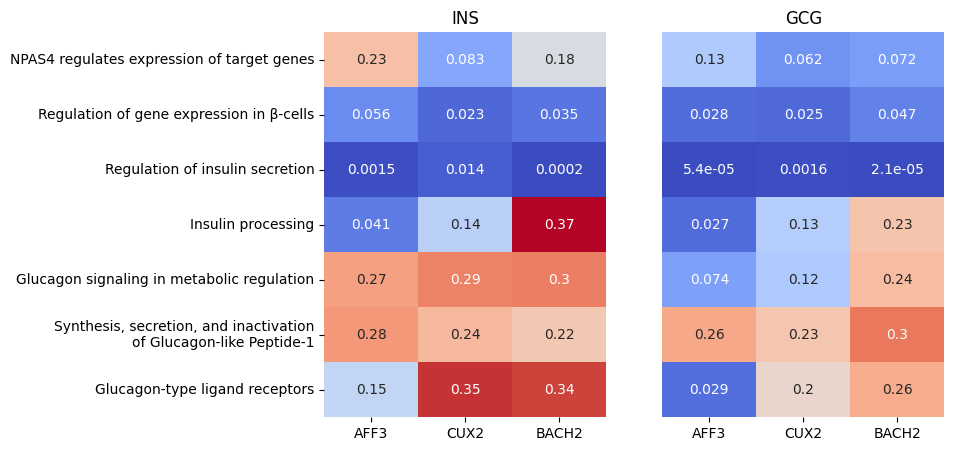

In [19]:
norm_ins_heatmap = create_heatmap(INS, pws_titles, norm=False)
norm_gcg_heatmap = create_heatmap(GCG, pws_titles, norm=False)
plot_ins_gcg_heatmap(norm_ins_heatmap, norm_gcg_heatmap, pws_titles, figsize=(8,5), output='case_study_results/ins_gcg_heatmap.pdf')

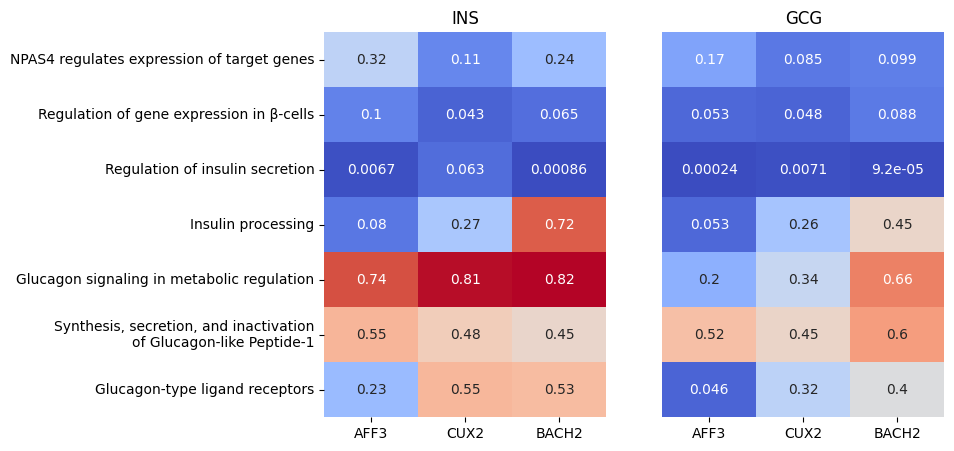

In [20]:
norm_ins_heatmap = create_heatmap(INS, pws_titles, norm=True)
norm_gcg_heatmap = create_heatmap(GCG, pws_titles, norm=True)
plot_ins_gcg_heatmap(norm_ins_heatmap, norm_gcg_heatmap, pws_titles, figsize=(8,5), output='case_study_results/ins_gcg_heatmap_norm.pdf')